# Update tensorflow versions for reading the saved model with h5 format

In [ ]:
# Uninstall current versions
!pip uninstall -y tensorflow keras

# Install specific versions
!pip install tensorflow==2.15.0 keras==2.15.0

# Restart runtime
import os
os.kill(os.getpid(), 9)

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


# Change the saved_model_path for running certain fold of the best model saved manually.

Mounted at /content/drive
Found 1686 images belonging to 4 classes.
106/106 [==============================] - 22s 128ms/step
Test Top-1 Accuracy: 0.8055
Test Top-2 Accuracy: 0.9852
Test Quadratic Weighted Kappa: 0.8812
Test Mean Absolute Error: 0.1969
Test Precision: 0.7523
Test Recall: 0.7496
Test F1 Score: 0.7508


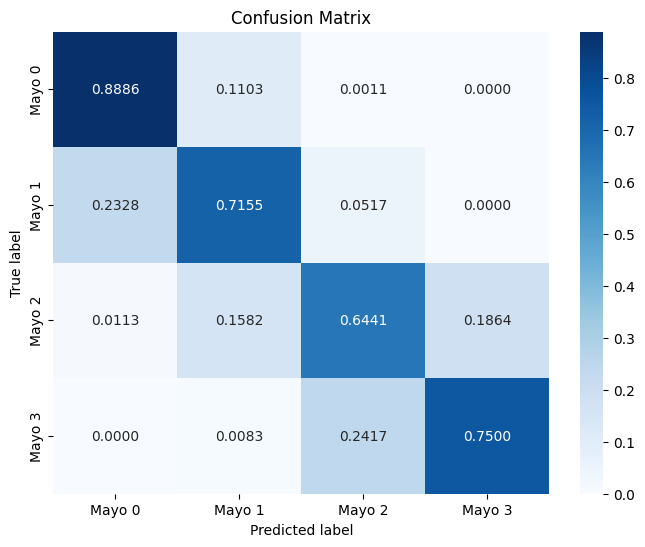

Grouped Top-1 Accuracy: 0.9668
Grouped Top-2 Accuracy: 0.8754
Grouped Kappa: 0.8846
Grouped Mean Absolute Error: 0.0332
Grouped Precision: 0.9459
Grouped Recall: 0.9388
Grouped F1 Score: 0.9423


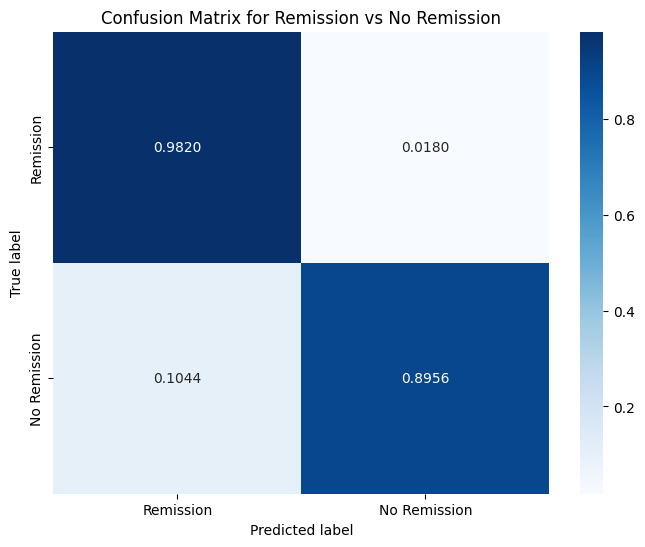

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, mean_absolute_error, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape, Conv2D, Layer
from tensorflow.keras.regularizers import l2

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paths to the test dataset and the saved model
test_path = '/content/drive/My Drive/LIMUC/test_set'
saved_model_path = '/content/drive/My Drive/LIMUC/Temp/RBSLF_best_model_fold_7.h5'

# Define class names
class_names = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
num_classes = len(class_names)

# Data generator for the test set
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(380, 380),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Define the Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(Layer):
    def __init__(self, output_dim, ratio=16):
        super(SqueezeExcitationLayer, self).__init__()
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(output_dim // ratio, activation='swish')
        self.dense2 = Dense(output_dim, activation='sigmoid')
        self.reshape = Reshape((1, 1, output_dim))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

# Define the Spatial Attention Layer
class SpatialAttentionLayer(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionLayer, self).__init__()
        self.conv1 = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

# Enable mixed precision
from tensorflow.keras.mixed_precision import Policy
mixed_precision_policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(mixed_precision_policy)

# Load the saved model with custom objects
custom_objects = {
    'SqueezeExcitationLayer': SqueezeExcitationLayer,
    'SpatialAttentionLayer': SpatialAttentionLayer
}

try:
    model = load_model(saved_model_path, custom_objects=custom_objects, compile=False)
except AttributeError as e:
    print(f"Error loading model: {e}")
    # Fallback to re-define and compile the model manually if necessary

    def build_efficientnet_model(num_classes):
        base_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))
        for layer in base_model.layers:
            layer.trainable = True

        inputs = tf.keras.Input(shape=(380, 380, 3))
        x = base_model(inputs, training=False)
        x = tf.keras.layers.BatchNormalization()(x)
        x = SqueezeExcitationLayer(base_model.output_shape[-1])(x)
        x = SpatialAttentionLayer()(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)

        # Use a placeholder loss function
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    model = build_efficientnet_model(num_classes)
    model.load_weights(saved_model_path)

# Evaluate the model on the test set
test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
test_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
test_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
test_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

# Calculate other metrics
test_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
test_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
test_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
test_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

# Print results
print(f"Test Top-1 Accuracy: {test_top1_accuracy:.4f}")
print(f"Test Top-2 Accuracy: {test_top2_accuracy:.4f}")
print(f"Test Quadratic Weighted Kappa: {test_kappa:.4f}")
print(f"Test Mean Absolute Error: {test_mae:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion Matrix for original classes
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title='Confusion Matrix')

# Group predictions into 'Remission' and 'No Remission'
test_y_true_grouped = np.where(test_y_true < 2, 0, 1)
test_y_pred_grouped = np.where(test_y_pred_top1 < 2, 0, 1)

# Calculate grouped Top-1 Accuracy
grouped_top1_accuracy = accuracy_score(test_y_true_grouped, test_y_pred_grouped)

# Calculate grouped Top-2 Accuracy
grouped_top2_accuracy = np.mean([
    test_y_true_grouped[i] in [0, 1] if 0 in top2_pred[i] or 1 in top2_pred[i] else 1 in [2, 3] for i in range(len(test_y_true_grouped))
])

# Calculate other grouped metrics
grouped_kappa = cohen_kappa_score(test_y_true_grouped, test_y_pred_grouped)
grouped_mae = mean_absolute_error(test_y_true_grouped, test_y_pred_grouped)
grouped_precision = precision_score(test_y_true_grouped, test_y_pred_grouped, average='macro')
grouped_recall = recall_score(test_y_true_grouped, test_y_pred_grouped, average='macro')
grouped_f1 = f1_score(test_y_true_grouped, test_y_pred_grouped, average='macro')

# Print grouped results
print(f"Grouped Top-1 Accuracy: {grouped_top1_accuracy:.4f}")
print(f"Grouped Top-2 Accuracy: {grouped_top2_accuracy:.4f}")
print(f"Grouped Kappa: {grouped_kappa:.4f}")
print(f"Grouped Mean Absolute Error: {grouped_mae:.4f}")
print(f"Grouped Precision: {grouped_precision:.4f}")
print(f"Grouped Recall: {grouped_recall:.4f}")
print(f"Grouped F1 Score: {grouped_f1:.4f}")

# Confusion Matrix for grouped classes
cm_grouped = confusion_matrix(test_y_true_grouped, test_y_pred_grouped)
cm_grouped_percentage = cm_grouped.astype('float') / cm_grouped.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm_grouped_percentage, ['Remission', 'No Remission'], title='Confusion Matrix for Remission vs No Remission')
